<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing_extensions import Literal
from IPython.display import clear_output
import random
import os

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

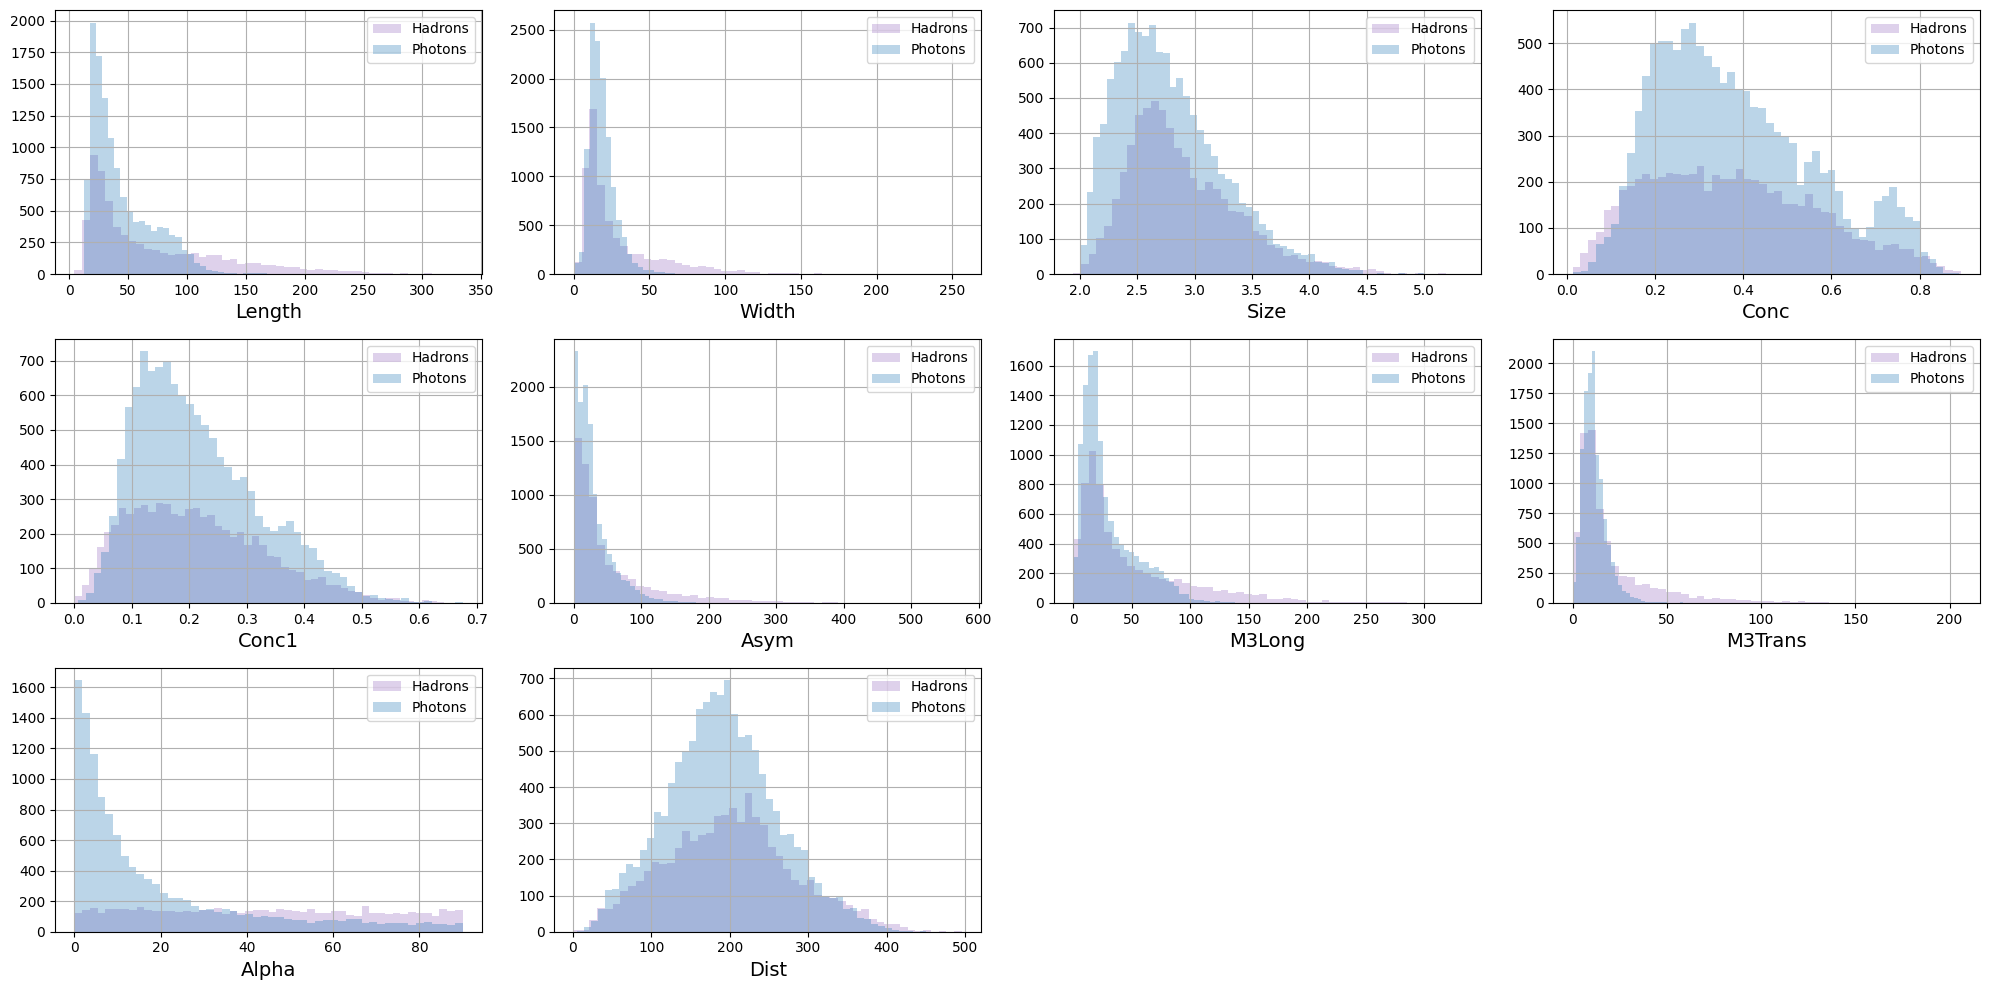

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

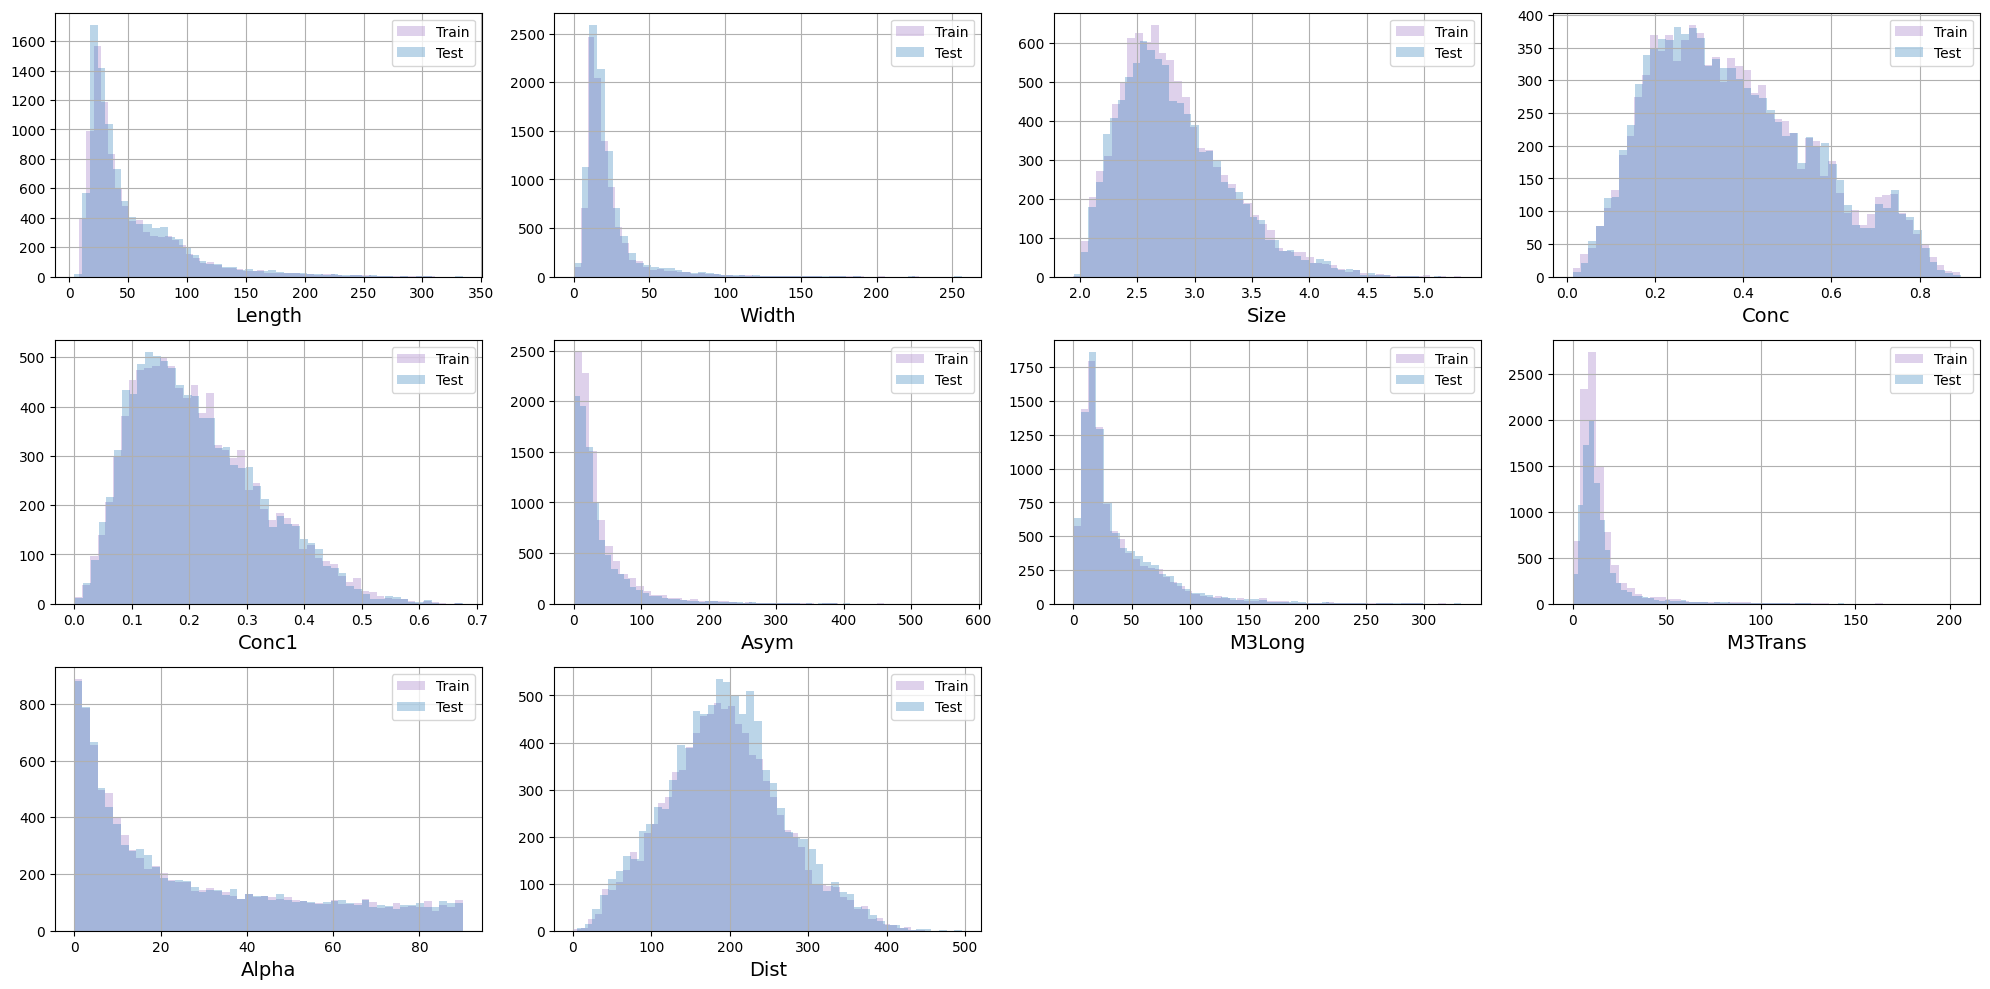

In [ ]:
plot_hists(
    X_train, X_test, names, label1="Train", label2="Test", bins=50
)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
from sklearn.preprocessing import QuantileTransformer

QT = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=13).fit(X_train)

In [ ]:
### YOUR CODE IS HERE ######
X_train = QT.transform(X_train)
X_test = QT.transform(X_test)
### THE END OF YOUR CODE ###

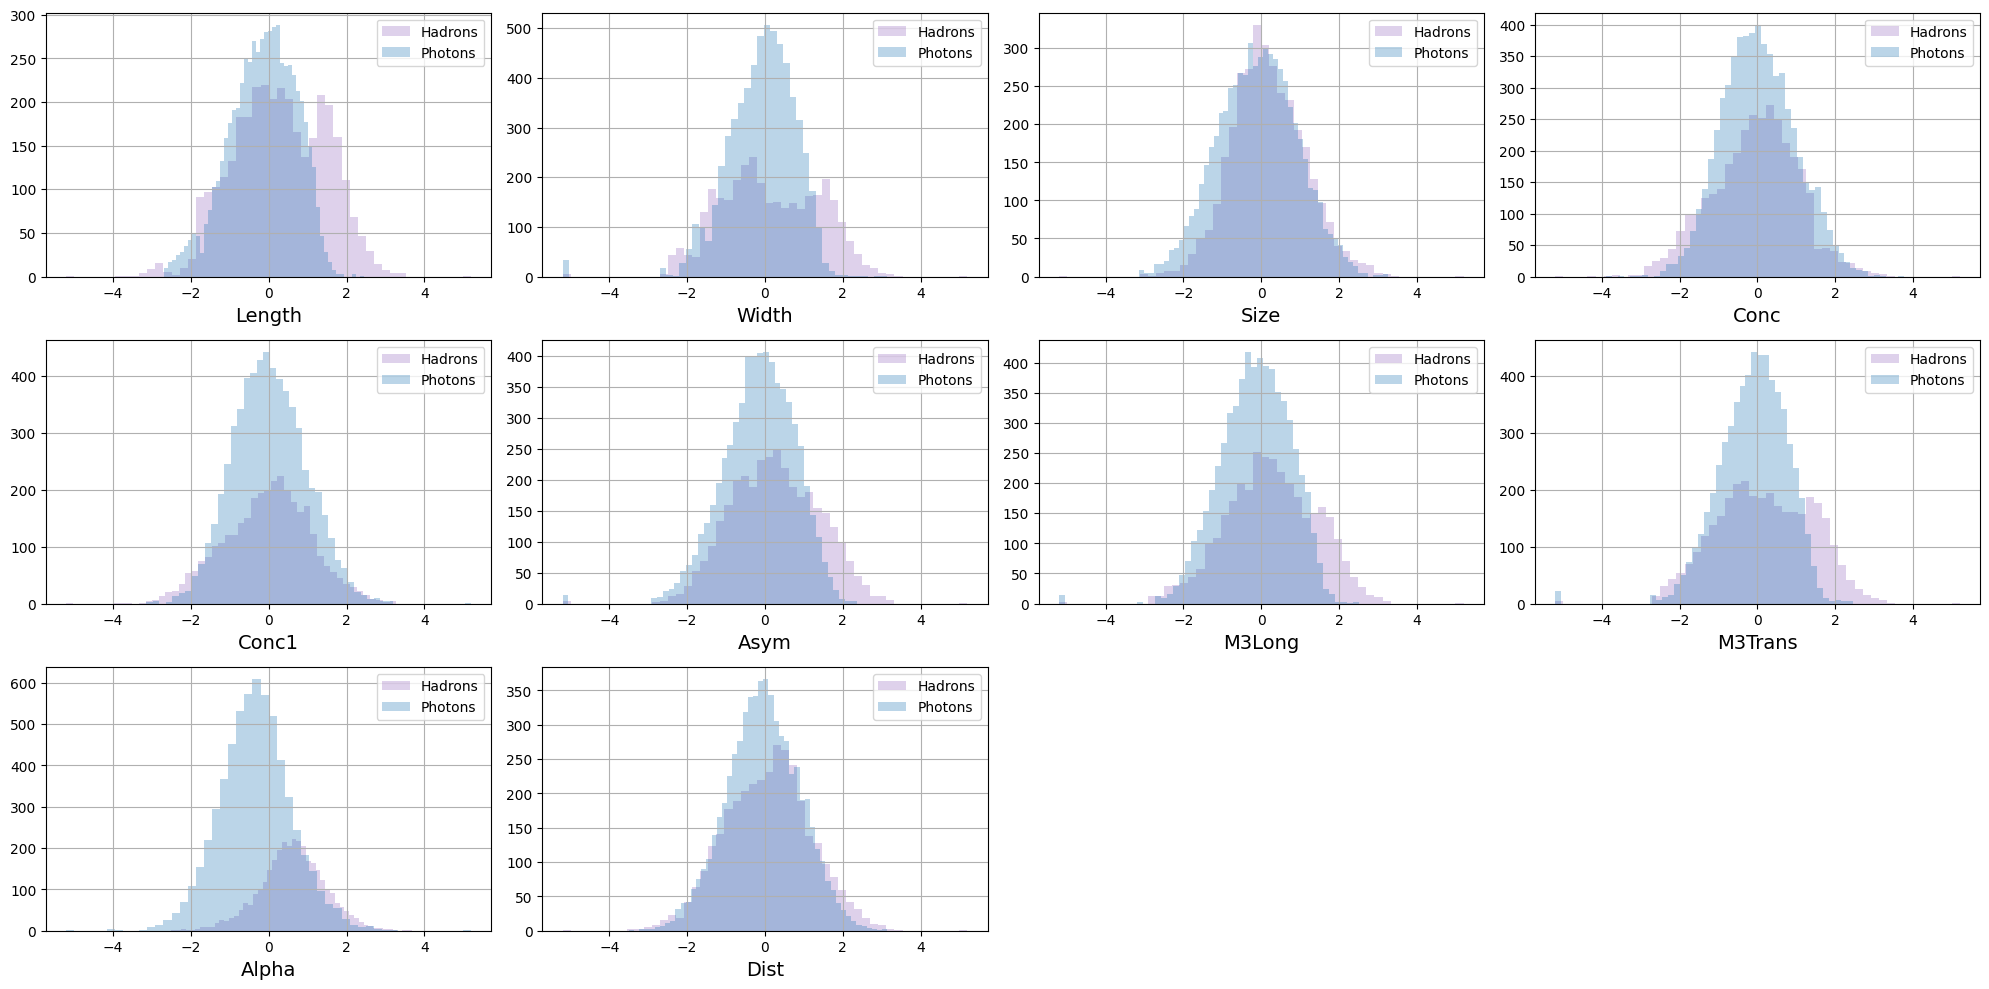

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

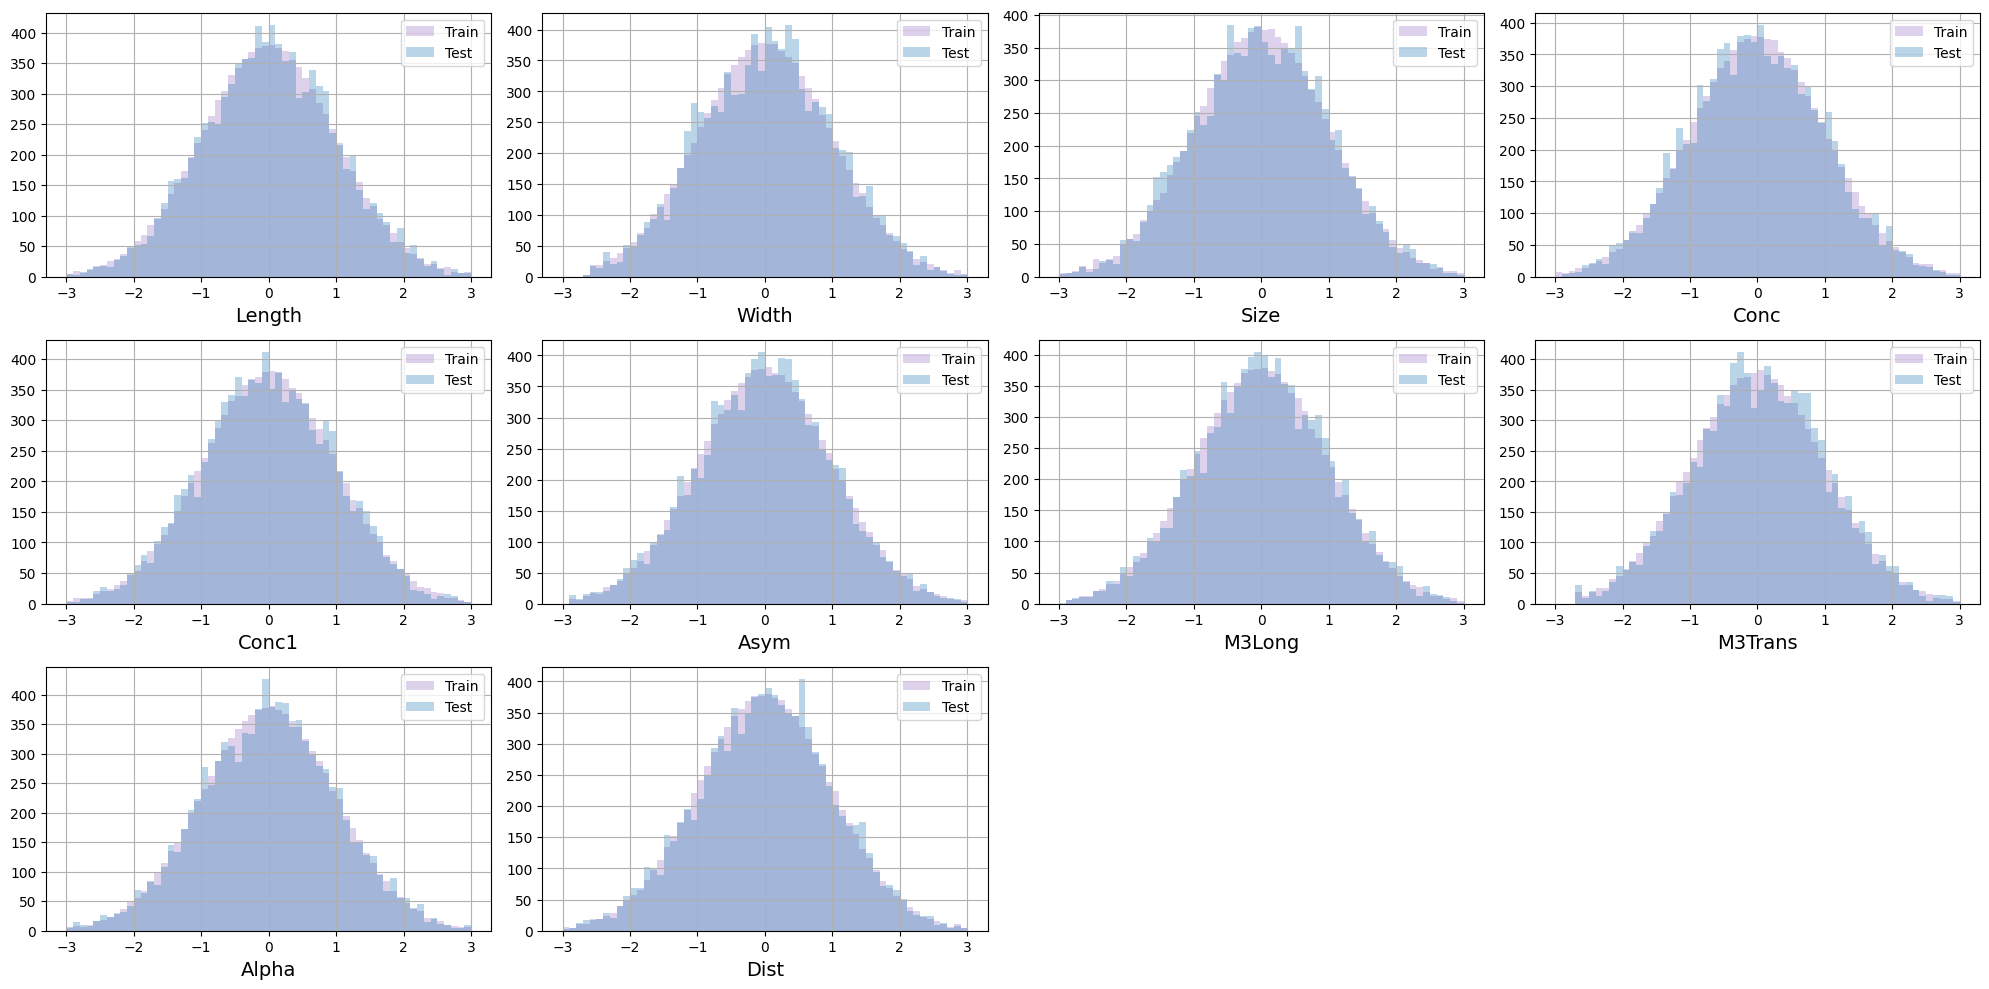

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [ ]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    generator.to(DEVICE)
    sht = torch.distributions.Normal(torch.zeros(latent_dim).to(DEVICE), torch.ones(latent_dim).to(DEVICE))
    z = sht.sample((y.shape[0], )).to(DEVICE)
    X_fake = generator(z, y)
    ### THE END OF YOUR CODE ###
    return X_fake

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.n_inputs = n_inputs
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

Функция активации здесь необязательна, хотя можно было бы использовать сигмоиду, например. Мы могли бы сказать, что-то типа в конце работы модели должна быть сигмоида, потому что дискриминатор является бинарным классификатором, а сигмоида - стандартная функция активации для него, и сигмоида переводит ответ в промежуток от 0 до 1, а в случае с классификацией интерпретируется как вероятность принадлежности к положительному классу.

Но на самом деле экспериментально (я проверила) она ни на что не влияет, да и нет тут какого-то универсального решения по функциям активации. Плюс тут моделька и так справится. Короче, я ее убрала.

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [ ]:
def other_agent_score(X_real, y_real, X_fake, y_fake):

    ### YOUR CODE IS HERE ######

    lr = LogisticRegression(n_jobs=-1)
    clf = GradientBoostingClassifier()

    X_real, X_fake = torch.cat((X_real, y_real), dim=1), torch.cat((X_fake, y_fake), dim=1)

    # new discriminator labels
    y_real, y_fake = torch.ones(X_real.shape[0]), torch.zeros(X_fake.shape[0])

    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, stratify=y_real, test_size=0.25, shuffle=True, random_state=42)
    X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake, y_fake, stratify=y_fake, test_size=0.25, shuffle=True, random_state=42)

    X_train = torch.cat((X_real_train, X_fake_train), dim=0).detach().cpu().numpy()
    X_test = torch.cat((X_real_test, X_fake_test), dim=0).detach().cpu().numpy()
    y_train = torch.cat((y_real_train, y_fake_train), dim=0).numpy()
    y_test = torch.cat((y_real_test, y_fake_test), dim=0).numpy()

    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    clf.fit(X_train, y_train)
    y_pred_clf = clf.predict(X_test)

    log_reg_score = accuracy_score(y_test, y_pred_lr)
    boosting_score = accuracy_score(y_test, y_pred_clf)

    ### THE END OF YOUR CODE ###

    print("Logistic regression score: " + str(log_reg_score))
    print("Boosting score: " + str(boosting_score))

    return log_reg_score, boosting_score

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [ ]:
# это отсюда, просто чуток переделанное: https://github.com/hse-ds/iad-applied-ds/blob/2024/seminars/01_GANs/01_GANs.ipynb

def gan_loss(discriminator, X_real, X_fake, y_cond, by: Literal["generator", "discriminator"] = "generator") -> torch.Tensor:
    if by == "generator":
        return torch.mean(discriminator(X_fake, y_cond))
    elif by == "discriminator":
        return (torch.mean(discriminator(X_real, y_cond)) - torch.mean(discriminator(X_fake, y_cond)))

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

        # for loss
        self.gen_losses = []
        self.discr_losses = []
        self.log_reg_scores = []
        self.boosting_scores = []

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        iter_i = 0

        # Fit GAN
        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}")
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                real_batch, cond_batch = real_batch.to(DEVICE), cond_batch.to(DEVICE)
                X_fake = generate(self.generator, cond_batch, self.latent_dim).to(DEVICE)

                # generator step
                if (i % (1 + self.n_critic)) < 1:
                    self.opt_gen.zero_grad()
                    gen_loss = gan_loss(
                        self.discriminator, real_batch, X_fake, cond_batch, "generator"
                    )
                    gen_loss.backward()
                    self.opt_gen.step()
                    self.gen_losses.append((iter_i, gen_loss.item()))

                # discriminator step
                else:
                    self.opt_disc.zero_grad()
                    discr_loss = gan_loss(
                        self.discriminator, real_batch, X_fake, cond_batch, "discriminator"
                    )
                    discr_loss.backward()
                    self.opt_disc.step()
                    self.discr_losses.append((iter_i, discr_loss.item()))

                    # restricting descriminator weights
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                iter_i += 1

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            # train samples
            idx = torch.randint(0, X_real.shape[0], (1000,))
            X_real_sub, y_cond_sub = X_real[idx], y_cond[idx]

            X_fake = generate(self.generator, y_cond_sub, self.latent_dim)

            log_reg_score, boosting_score = other_agent_score(X_real_sub, y_cond_sub, X_fake, y_cond_sub)
            self.log_reg_scores.append((epoch, log_reg_score))
            self.boosting_scores.append((epoch, boosting_score))

            clear_output(wait=True)
            plt.figure(figsize=(17, 5))

            # generator loss
            plt.subplot(1, 3, 1)
            plt.xlabel("Iteration")
            plt.ylabel("Generator loss")
            plt.plot([p[0] for p in self.gen_losses], [p[1] for p in self.gen_losses])

            # discriminator loss
            plt.subplot(1, 3, 2)
            plt.xlabel("Iteration")
            plt.ylabel("Discriminator loss")
            plt.plot([p[0] for p in self.discr_losses], [p[1] for p in self.discr_losses],
                color="orange")

            # scores
            plt.subplot(1, 3, 3)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.plot([p[0] for p in self.log_reg_scores], [p[1] for p in self.log_reg_scores],
                     label='LogReg score', color='purple')
            plt.plot([p[0] for p in self.boosting_scores], [p[1] for p in self.boosting_scores],
                     label='GrBoosting score', color='green')
            plt.legend(loc="best")
            plt.show()
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

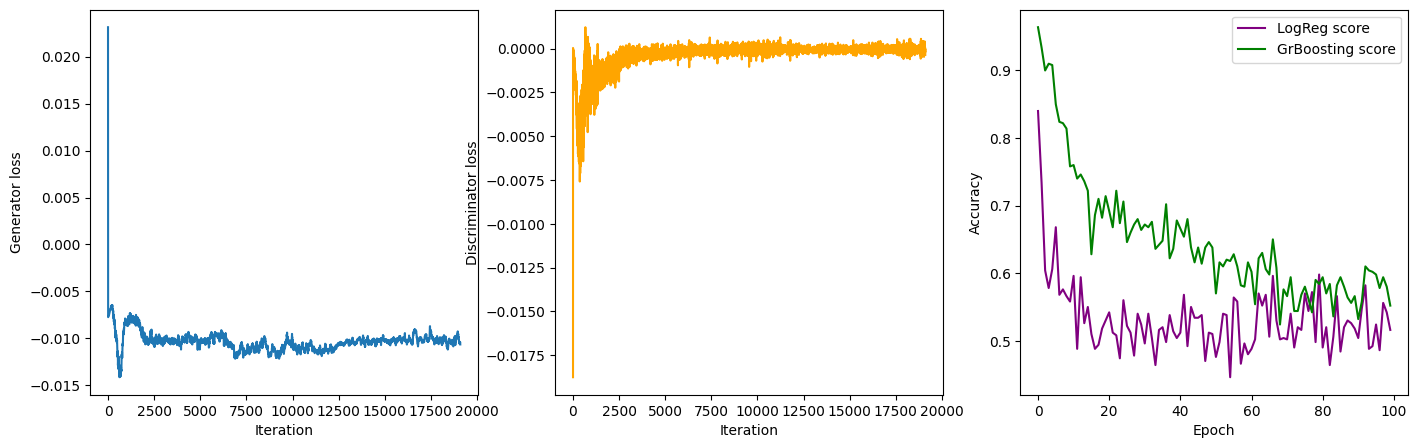

CPU times: user 3min 32s, sys: 11.3 s, total: 3min 43s
Wall time: 3min 40s


In [ ]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

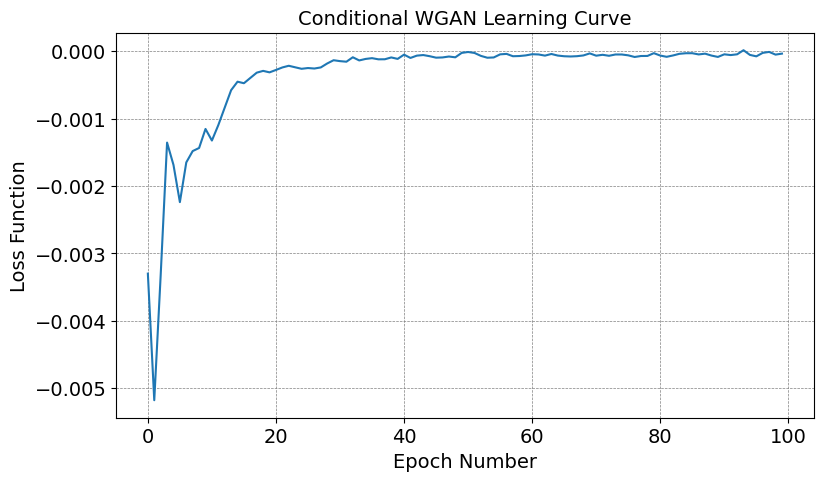

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(visible=1, linestyle="--", linewidth=0.5, color="0.5") # b=1 не работает, поэтому visible
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [ ]:
### YOUR CODE IS HERE ######
X_fake_train_norm = generate(fitter.generator, torch.tensor(y_train, dtype=torch.float, device=DEVICE), latent_dim).detach().cpu().numpy()
X_fake_train = QT.inverse_transform(X_fake_train_norm)

X_train_norm = X_train.copy()
X_train = QT.inverse_transform(X_train_norm)

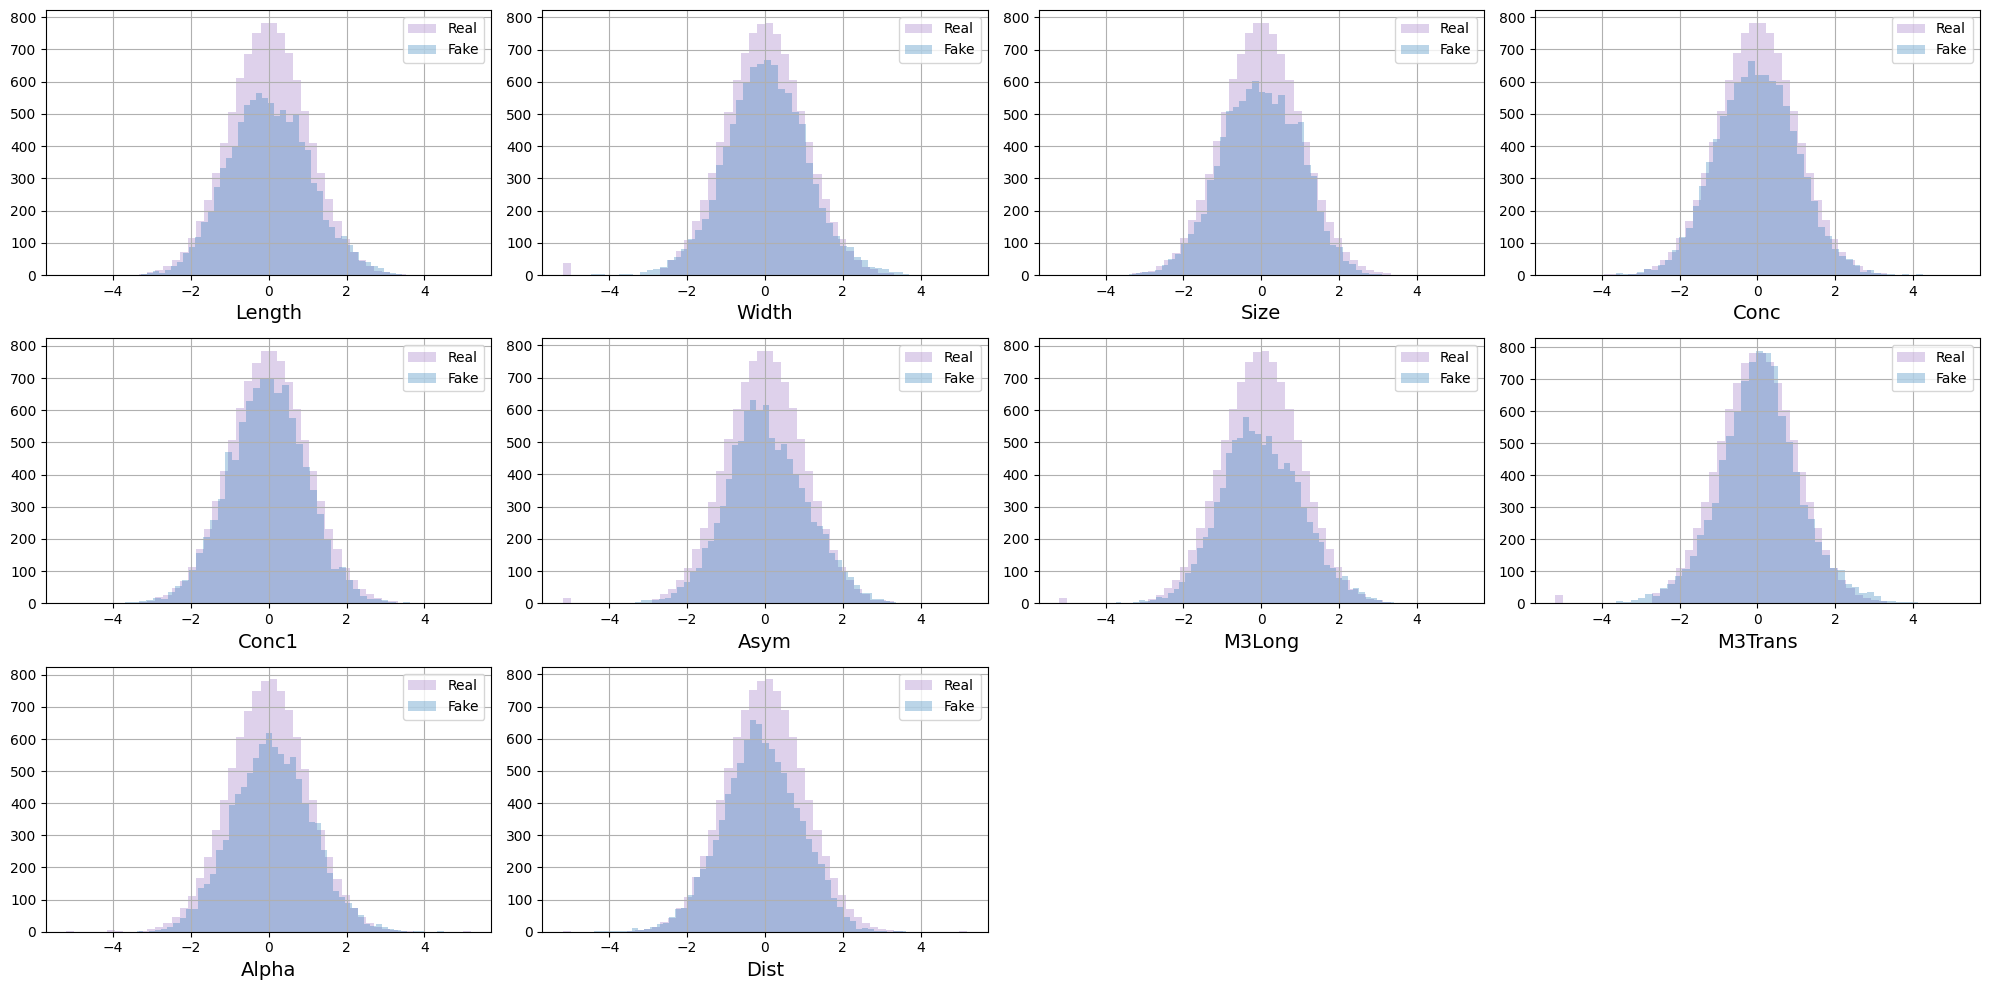

In [ ]:
plot_hists(X_train_norm, X_fake_train_norm, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test_norm = generate(fitter.generator, torch.tensor(y_test, dtype=torch.float, device=DEVICE), latent_dim).detach().cpu().numpy()
X_fake_test = QT.inverse_transform(X_fake_test_norm)

X_test_norm = X_test.copy()
X_test = QT.inverse_transform(X_test_norm)

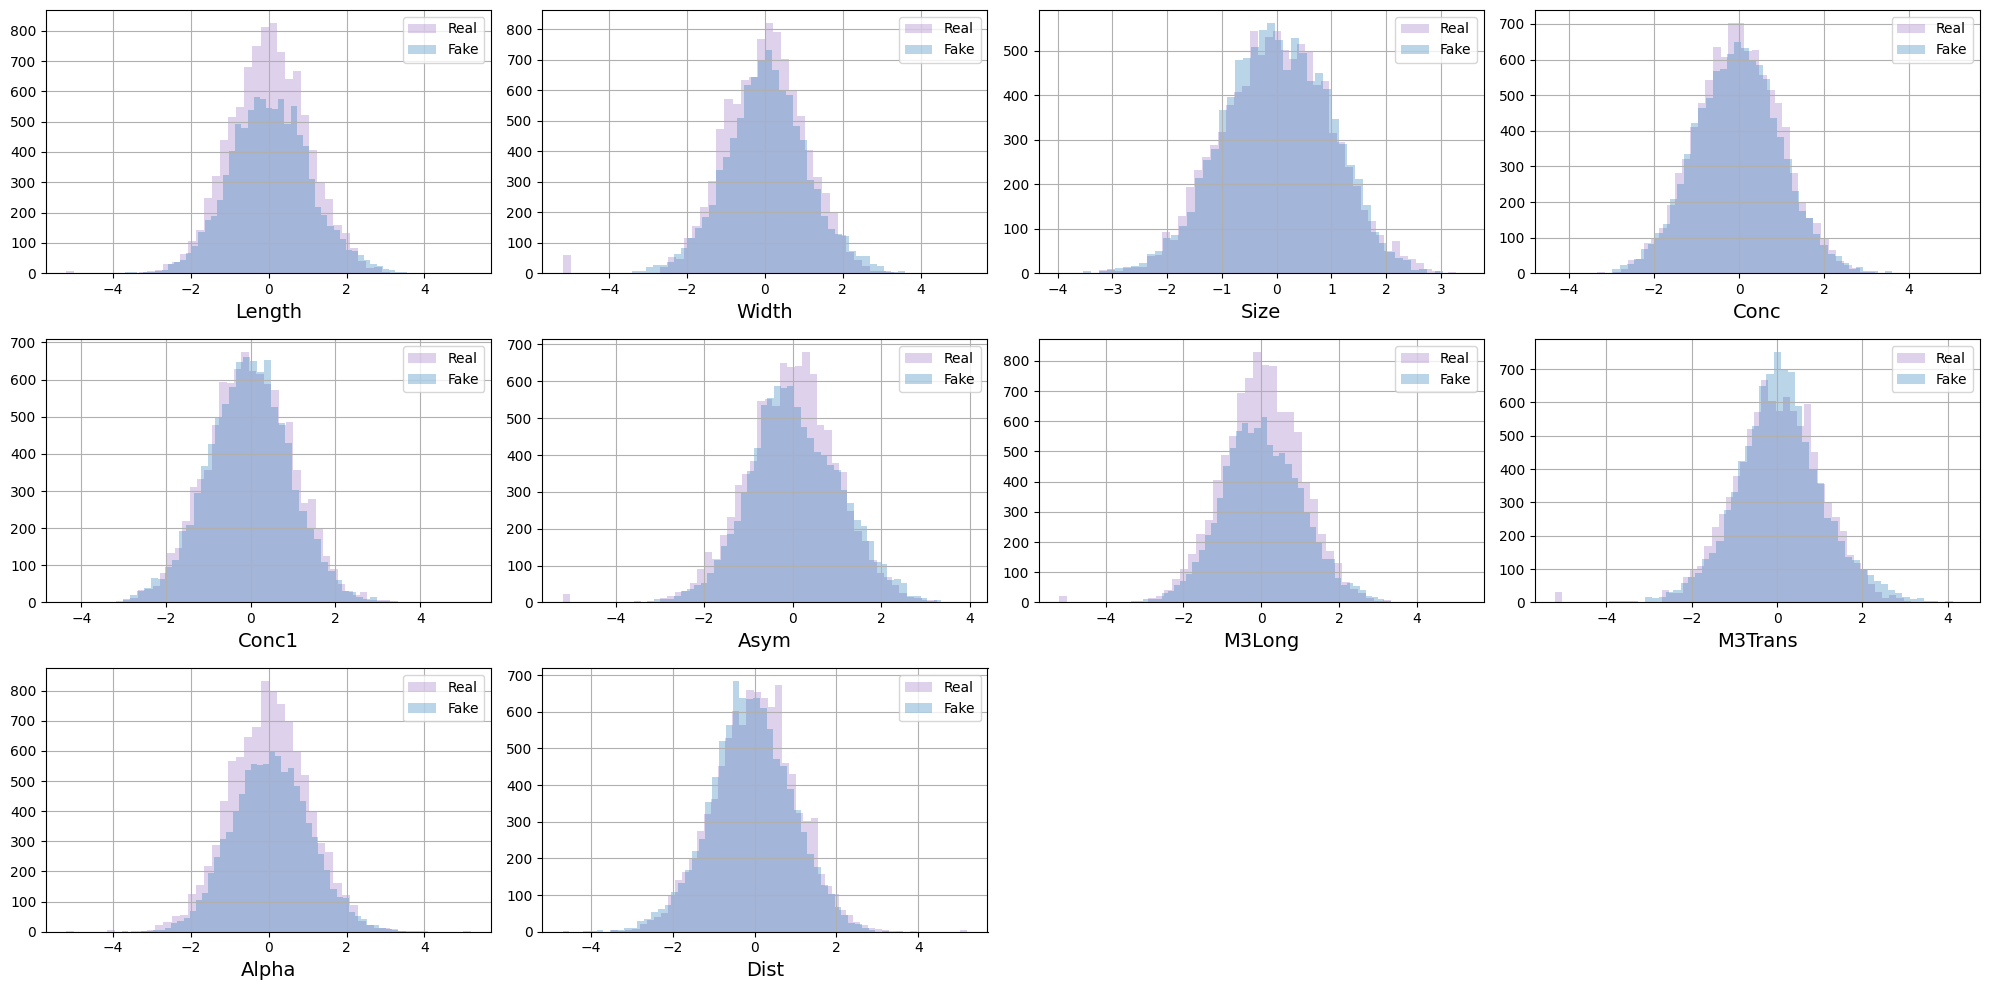

In [ ]:
plot_hists(X_test_norm, X_fake_test_norm, names, label1="Real", label2="Fake", bins=50)
### THE END OF YOUR CODE ###

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6886366169431481


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


**Описание эксперимента:**

Практически весь код я писала с опорой на семинар, этого оказалось достаточно. Не знаю, насколько подробно стоит здесь описывать код, поскольку в основных местах он закомменчен. Существенные проблемы были с размерностями и (местами) с типами данных, плюс я иногда что-то забывала переложить на девайс. Мне честно стыдно, что на дебаг ушло некоторое количество лишних часов, можно было просто чуть внимательнее, зато результат вроде бы неплохой. Плюс я сначала весьма наивно напрямую скопировала функцию `gan_loss` из семинара не глядя и, только когда код сломался, додумалась, что надо бы адаптировать и переписать.

К слову, о результате. Больше всего нас бы удовлетворил ROC AUC = 0.5, потому что это бы соответствовало случаю, когда классификатор не может разделить реальные и фейковые данные. В нашем случае ROC AUC около 0.7, что говорит о том, что есть куда улучшать качество модельки.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

Функцию я переписала, но вот по факту она нам не нужна, потому что мы используем noise_scheduler, так что она скорее здесь просто для красоты. Такие дела.

In [ ]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    x = x * (1 - amount) + noise * amount
    ### THE END OF YOUR CODE ###
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [ ]:
!pip install diffusers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.7 MB/s eta 0:00:00


In [ ]:
from diffusers import DDPMScheduler

clip_sample (bool, defaults to True) — Clip the predicted sample for numerical stability.

clip_sample_range (float, defaults to 1.0) — The maximum magnitude for sample clipping. Valid only when clip_sample=True. Подобрала, посмотрев на графики по трейну и тесту.




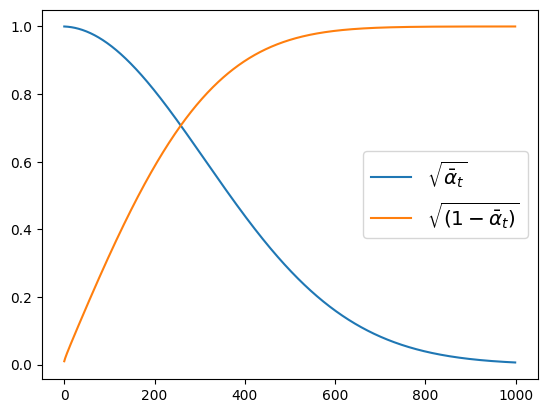

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=True, clip_sample_range=3.0)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        ### YOUR CODE IS HERE ######
        self.class_embedding = nn.Embedding(2, self.n_inputs)
        self.timestep_embedding = nn.Embedding(1000, self.n_inputs)
        self.net = nn.Sequential(
            nn.Linear(3 * self.n_inputs, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            # the model from the article also has some dropout and it is 0.1, so I left it this way
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, t, y):
        classes_ = self.class_embedding(y.squeeze())
        timesteps_ = self.timestep_embedding(t)
        # at first here was an addition, not concatenation but for some strange reason concatenation is better (shouldn't be...)
        new = torch.cat((z, classes_, timesteps_), dim = 1)
        return self.net(new)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    ### YOUR CODE IS HERE ######
    model = model.to(DEVICE).eval()
    x_ = torch.randn(y.shape[0], latent_dim).to(DEVICE)
    # using scheduler
    for _, t in tqdm(enumerate(sheduler.timesteps)):
        with torch.no_grad():
            t = t.to(DEVICE)
            # format long() is needed, otherwise it does not work
            ts = (torch.ones(y.shape[0], ).to(DEVICE) * t)
            resid = model(x_, ts.long().to(DEVICE), y.long())
        x_ = sheduler.step(resid, t, x_).prev_sample
    X_fake = x_
    ### THE END OF YOUR CODE ###
    return X_fake

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

Было не очень честно то, что в блок с диффузионкой как базу скопировали код гана, пришлось переделывать. Например, для диффузионки уже не нужны n_critic, поэтому я их убрала. Моя диффузионка частично с опорой на статью, частично с опорой на "лишь бы работало", так что это кошмарный монстр (который for some reason выдал в итоге красивый результат, приятно).

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model, # model, not "generator"
        batch_size=32, # should be larger
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.loss_fc = nn.MSELoss() # loss function
        # the scheduler which I used in the previous semester, one of the best, I guess
        self.scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(self.opt_gen, T_max=100, eta_min=0, verbose=False)
        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        # this stuff is from the seminar as well, as far as I remember
        self.loss_history = []
        self.gen_losses = []
        self.log_reg_scores = []
        self.boosting_scores = []

        iter_i = 0

        # Fit diffusion model
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            print(f'Epoch: {epoch + 1}')
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                # the long() format is needed here
                real_batch, cond_batch = real_batch.to(DEVICE), cond_batch.long().to(DEVICE)
                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, 999, (real_batch.shape[0], )).long().to(DEVICE)
                x_noised = noise_scheduler.add_noise(real_batch, noise, timesteps)
                pred_noise = self.model(x_noised, timesteps, cond_batch)

                # step
                self.opt_gen.zero_grad()
                gen_loss = self.loss_fc(pred_noise, noise)
                gen_loss.backward()
                self.opt_gen.step()
                loss_epoch += gen_loss.item()
                self.gen_losses.append((iter_i, gen_loss.item() / real_batch.shape[0]))
                iter_i += 1
                ### THE END OF YOUR CODE ###

            # calculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            idx = torch.randint(0, X_real.shape[0], (1000, ))
            X_real_sub, y_cond_sub = X_real[idx], y_cond[idx]
            X_fake = generate_with_diffusion(self.model, y_cond_sub, self.latent_dim, noise_scheduler)
            log_reg_score, boosting_score = other_agent_score(X_real_sub, y_cond_sub, X_fake, y_cond_sub)
            self.log_reg_scores.append((epoch, log_reg_score))
            self.boosting_scores.append((epoch, boosting_score))

            clear_output(wait=True)
            plt.figure(figsize=(16, 6))

            # generator loss
            plt.subplot(1, 2, 1)
            plt.xlabel("Iteration")
            plt.ylabel("Generator loss")
            plt.plot([p[0] for p in self.gen_losses], [p[1] for p in self.gen_losses])

            # scores
            plt.subplot(1, 2, 2)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.plot([p[0] for p in self.log_reg_scores], [p[1] for p in self.log_reg_scores],
                     label='LogReg score', color='purple')
            plt.plot([p[0] for p in self.boosting_scores], [p[1] for p in self.boosting_scores],
                     label='GrBoosting score', color='green')
            plt.legend(loc="best")
            plt.show()

            # to change lr so it would not stay constant
            self.scheduler_.step()
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

In [ ]:
# needed, cause we did some inverse transformation before
X_train, X_test, y_train, y_test = train_test_split(
X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

QT = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=13).fit(X_train)

X_train = QT.transform(X_train)
X_test = QT.transform(X_test)

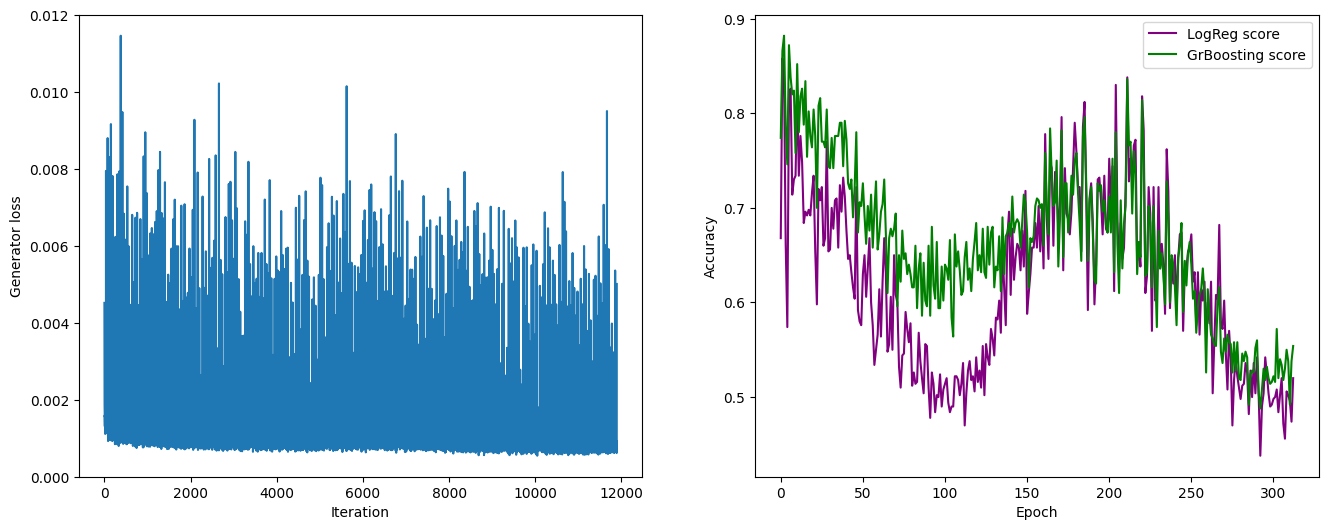

CPU times: user 46min 42s, sys: 43.1 s, total: 47min 25s
Wall time: 48min 1s


In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=256,
    n_epochs=313,
    latent_dim=latent_dim,
    lr=0.001, # chosen as one of the best options
)
diffusionFitter.fit(X_train, y_train)

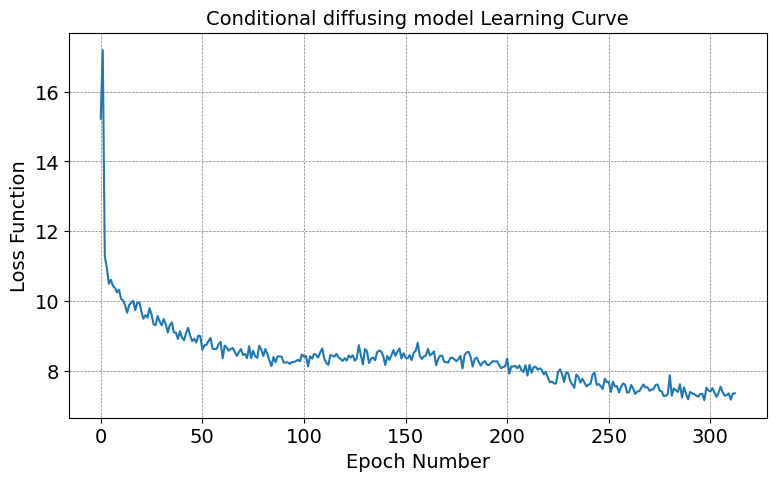

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(visible=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [ ]:
### YOUR CODE IS HERE ######
X_fake_train_norm = generate_with_diffusion(diffusionFitter.model, torch.tensor(y_train, dtype=torch.float, device=DEVICE), latent_dim, noise_scheduler).detach().cpu().numpy()
X_fake_train = QT.inverse_transform(X_fake_train_norm)

X_train_norm = X_train.copy()
X_train = QT.inverse_transform(X_train_norm)

1000it [01:36, 10.33it/s]


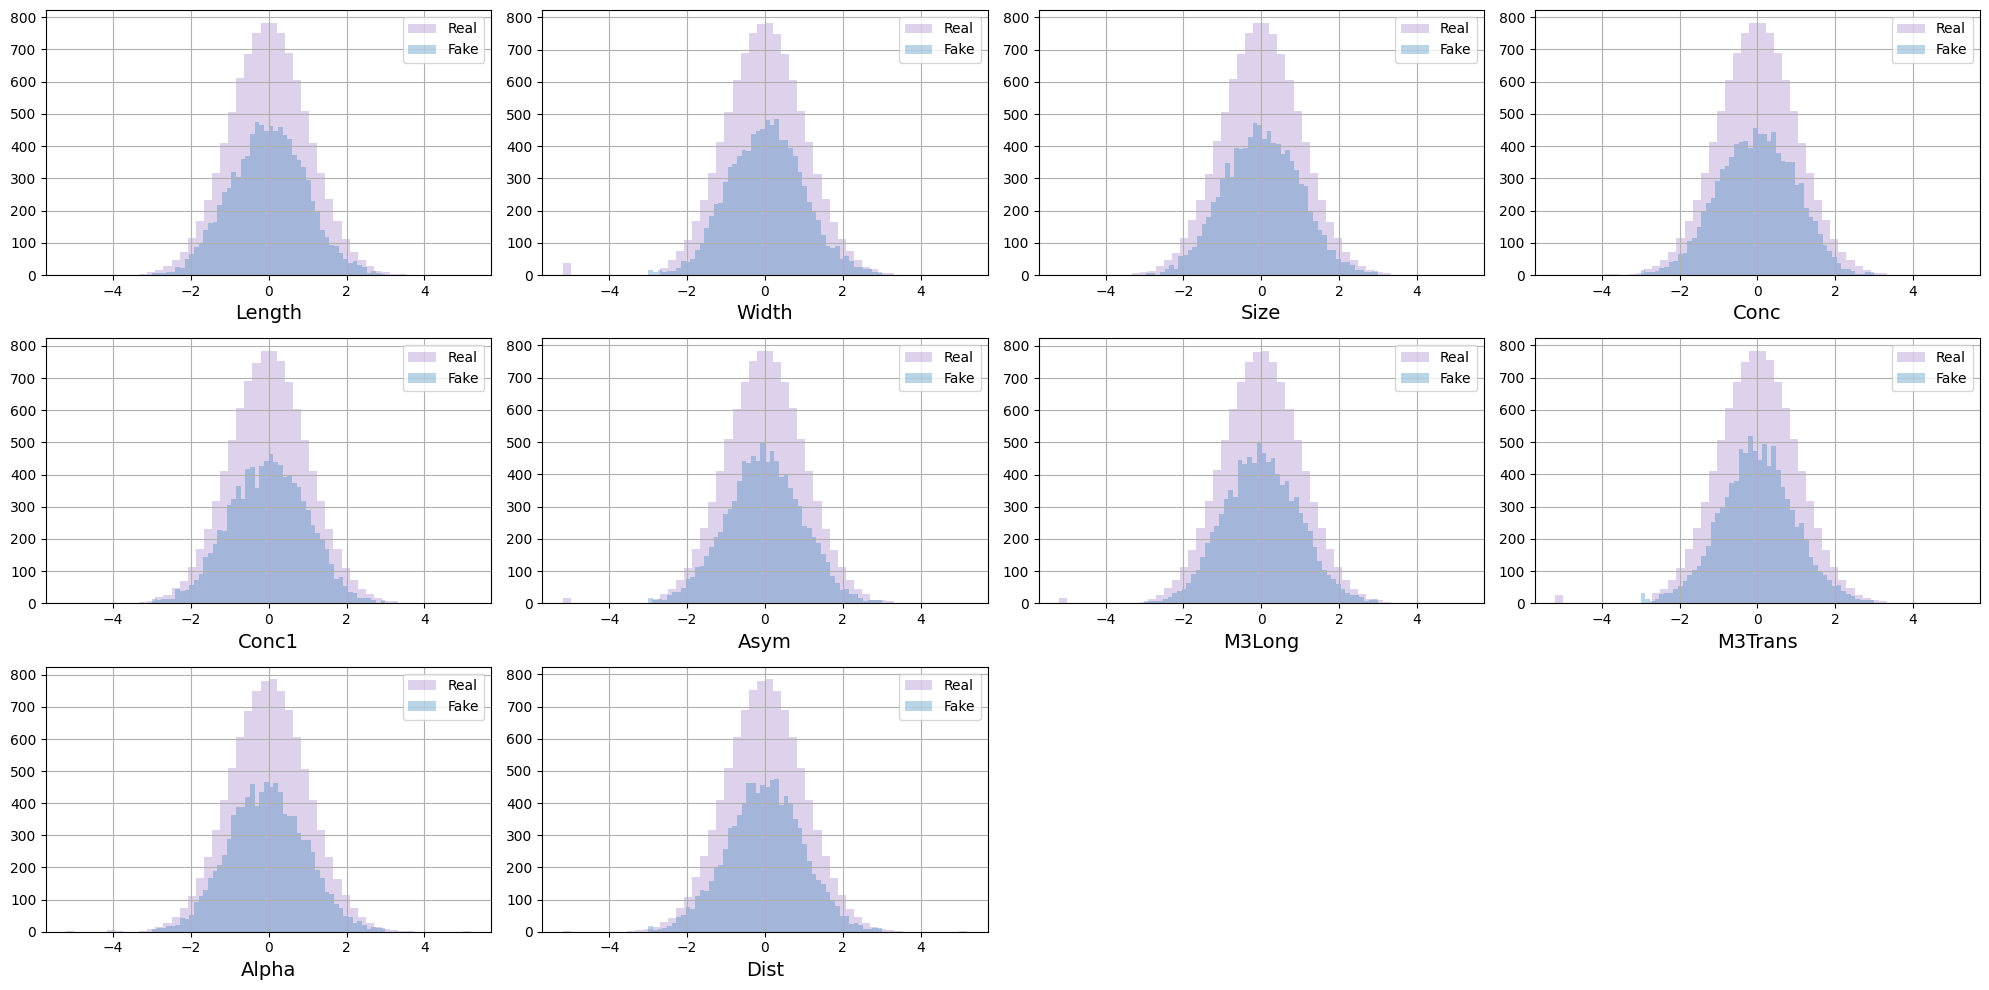

In [ ]:
plot_hists(X_train_norm, X_fake_train_norm, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test_norm = generate_with_diffusion(diffusionFitter.model, torch.tensor(y_test, dtype=torch.float, device=DEVICE), latent_dim, noise_scheduler).detach().cpu().numpy()
X_fake_test = QT.inverse_transform(X_fake_test_norm)

X_test_norm = X_test.copy()
X_test = QT.inverse_transform(X_test_norm)

1000it [01:08, 14.51it/s]


In [ ]:
plot_hists(X_test_norm, X_fake_test_norm, names, label1="Real", label2="Fake", bins=50)

Считаем ROC AUC

In [ ]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [ ]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

### Итак, отчет

Я начала писать диффузионку с той архитектурой, которую нам дали, но она приносила результат в виде ROC AUC = 0.92-0.99, что было не очень здорово, поэтому я отправилась читать статью по  DDPM.

Почитала также, что стоит добавить эмбеддинги классов и timesteps, что и сделала. Встроить их было не очень просто, потому что я снова запуталась в размерностях, зато когда получилось, модель стала выдавать результат получше. Правда, стоит заметить, что параллельно я меняла и архитектуру сетки, придя в итоге к вот той, что выше в коде.
Размерности и количество дополнительных слоев я потом несколько раз тыкала и выяснила, что ни большее количество слоев, ни большие размерности особо не помогают, а иногда даже мешают. Так что за максимальное количество нейронов я решила взять 256, а потом уменьшила до 128, степени двойки, все как положено.

Собственно, когда я добавила классы и таймстеп, вот эта часть кода сначала выглядела так:



```
def forward(self, z, t, y):
    classes_ = self.class_embedding(y.squeeze())
    timesteps_ = self.timestep_embedding(t)
    new = z + classes_ + timesteps_
    return self.net(new)
```

Тут ROC AUC получился равным 0.78, а графики выглядели так (313 итераций, размер батча 256, lr = 0.001):

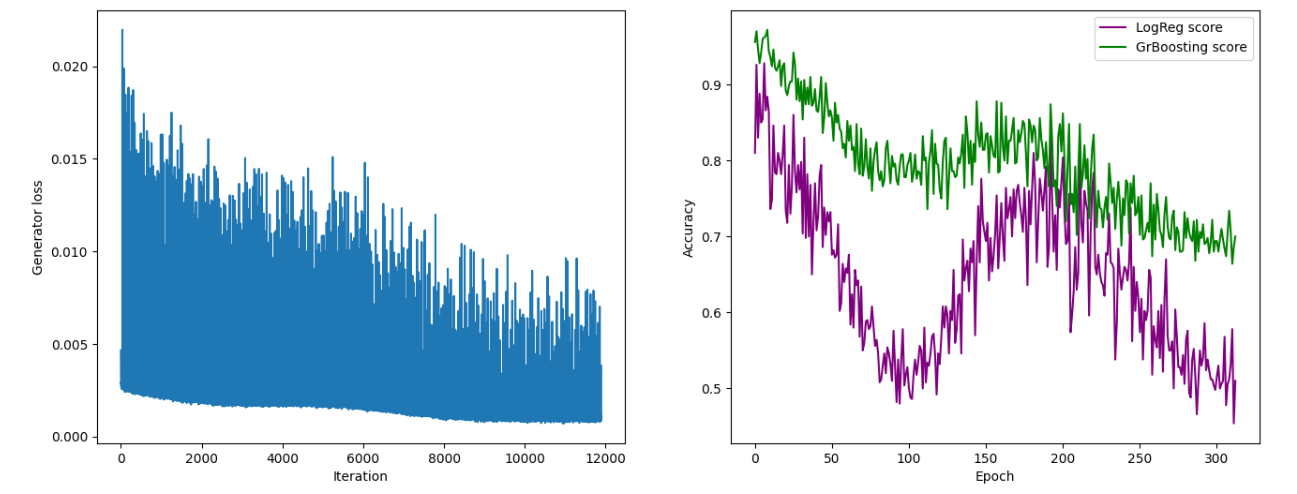


Левый график может показаться не очень красивым, в нем много всплесков, но я решила оставить так, чтобы было видно, как на самом деле выглядит процесс обучения.

Вообще идея как раз была в том, чтобы складывать эмбеддинги, вот тут вот объяснение (https://ai.stackexchange.com/questions/35990/why-are-embeddings-added-not-concatenated), но результат получился все еще не супер хорошим, хотя диффузионка явно может лучше, поэтому я решила попробовать сконтатить и сделала вот так:

```
def forward(self, z, t, y):
    classes_ = self.class_embedding(y.squeeze()) # к слову, что надо так, я додумалась спустя сутки, ы.......
    timesteps_ = self.timestep_embedding(t)
    new = torch.cat((z, classes_, timesteps_), dim = 1)
    return self.net(new)
```

На удивление, график сразу начал со скора поменьше, что было довольно неплохо. Я точно так же выставила количество эпох 313 (если что, это просто число красивое, никакой логики, кроме идеи, что эпох надо побольше), остальные гиперпараметры оставила прежними. Считалось где-то час, зато потом... Потом ROC AUC выдал результат примерно 0.6 (всего-то трое суток на одну диффузионку и страданий, что все сломалось, ничего не рабоооотает). И это наконец-то круче, чем WGAN, дальше я даже трогать ничего не стала, чтобы не сломать случайно еще раз........


А ломала я модель часто, вот так вот порой выглядели гистограммы (can relate ко всему, что происходило в чате):

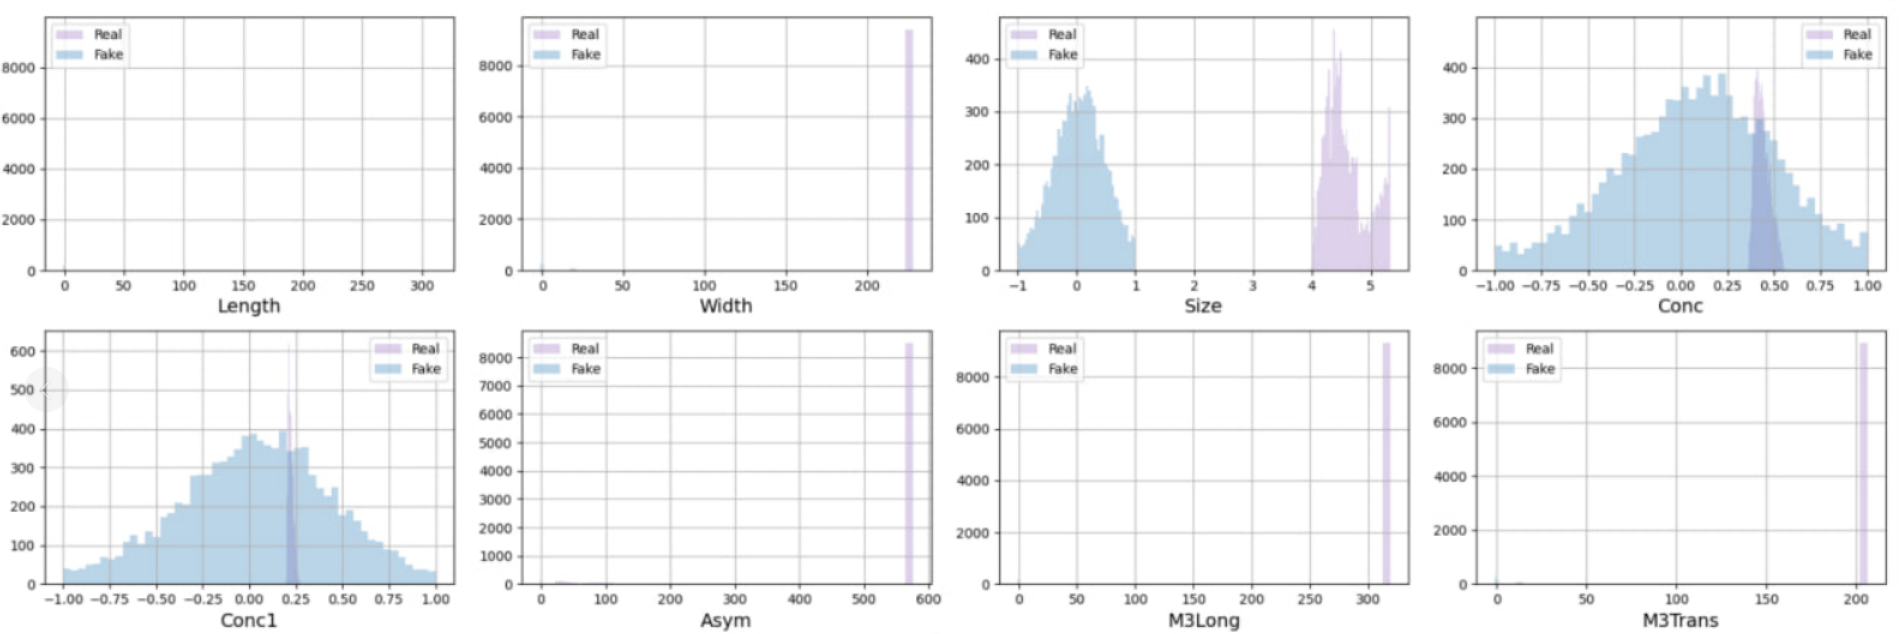

Пожалуй, стоит объяснить выбор шедулера и lr. Дело в том, что еще в прошлом семестре я наткнулась на вот такую замечательную вещь: https://www.kaggle.com/code/billiemage/understand-lr-scheduler-with-simple-examples. Здесь по логике больше подходил CosineAnnealingLR, нужно было что-то скачущее, потому что я плохо понимала, как тут внутри модель себя ведет порой, слишком много абстракции получилось, да и ExponentialLR, CyclicLR я уже пробовала. Вот тут вот про него поболбше: https://wiki.cloudfactory.com/docs/mp-wiki/scheduler/cosineannealinglr. Дефолтно там T_max стоит на 1000, но я задолбалась все это учить и так, так что я поставила поменьше - 100. Вообще мне просто теперь прикольно шедулеры из того ноутбука на кэггле запихивать в модельки и смотреть, поможет или нет, потому что штука правда кайфовая.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

Было прикольно, но больно.